In [1]:
import numpy as np
import random
from midiutil import MIDIFile
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from keras.models import load_model

2025-01-07 10:05:19.408630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the model for prediction
model_1 = load_model('evaluator_1.keras')
model_2 = load_model('evaluator_2.keras')
model_3 = load_model('evaluator_3.keras')
model_central = load_model('evaluator_central.keras')

In [3]:
POPULATION_SIZE = 10
MAX_GENERATIONS = 10
MUTATION_RATE = 0.05
FREQUENCY = 2

# The scaleStructures dictionary provides interval patterns for different musical scales, defining how to construct each scale starting from any root note.
# The patterns are repeated twice to ensure they cover a full two-octave range.
# This dictionary allows the program to build various scales dynamically based on user input for key and scale type, facilitating the creation of diverse musical sequences.
scaleStructures = {
    "major": [2, 2, 1, 2, 2, 2, 1] * 2,
    "minor": [2, 1, 2, 2, 1, 2, 2] * 2,
}

# MIDI codes for notes starting from A below middle C
scales = {}
a3 = 45 # MIDI code for A3 (A below middle C)
currentCode = a3

# Generate MIDI note codes for all notes including sharps and flats
for note in "abcdefg":

    scales[note] = currentCode # Assign the current code to the note

    # Add the sharp note (if applicable)
    if note not in ["b", "e"]:
        scales[f"{note}#"] = currentCode + 1 # Sharp notes are one semitone above the current note
        currentCode += 2 # Move to the next note

    # Add the flat note (if applicable)
    if note not in ["c", "f"]:
        scales[f"{note}b"] = currentCode - 1 # Flat notes are one semitone below the current note
        currentCode += 2 # Move to the next note
    else:
        currentCode += 1 # Move to the next note without adding a flat

In [4]:
print("max generation: ", MAX_GENERATIONS)
interval_step = int(np.ceil(MAX_GENERATIONS/FREQUENCY))
print("interval step: ", interval_step)
interval_val = list(range(interval_step, MAX_GENERATIONS + 1, interval_step))
print("generations when to send genomes to central island: ", interval_val)

max generation:  10
interval step:  5
generations when to send genomes to central island:  [5, 10]


In [5]:
print(scales)

{'a': 45, 'a#': 46, 'ab': 46, 'b': 49, 'bb': 48, 'c': 51, 'c#': 52, 'd': 54, 'd#': 55, 'db': 55, 'e': 58, 'eb': 57, 'f': 60, 'f#': 61, 'g': 63, 'g#': 64, 'gb': 64}


In [6]:
def getUserInput(userinput, validOptions):

    """Gets user input and validates it."""

    # Infinite loop to continuously prompt the user until a valid input is received
    while True:

        # Read user input, converting it to lowercase and stripping any leading/trailing whitespace
        choice = userinput.lower().strip()

        # Check if the user input matches any of the valid options
        if choice in validOptions:

            # If a valid option is chosen, return it and exit the loop
            return choice
        
        # If the input is not valid, inform the user and prompt again
        print("Invalid choice. Please try again.")

In [7]:
def buildScale(root, key):

    """Builds scale based on the root and key."""
    
    # Retrieve the MIDI note value for the root note from the scales dictionary
    # ex: a3: 45
    rootCode = scales[root]
    
    # Retrieve the pattern of intervals (in semitones) for the specified scale type from the scaleStructures dictionary
    # major/ minor
    pattern = scaleStructures[key]
    
    # Initialize the scale list with the root note's MIDI note value
    scale = [rootCode]

    # Iterate over the interval pattern to construct the full scale
    for step in pattern:

        # Add the interval step to the rootCode to get the next note in the scale
        rootCode += step
        
        # Append the new note's MIDI note value to the scale list
        scale.append(rootCode)

    # print(scale)

    return scale

In [8]:
buildScale('d#', 'major')

[55, 57, 59, 60, 62, 64, 66, 67, 69, 71, 72, 74, 76, 78, 79]

In [9]:
def flatten(arr):

    """Flattens a 2D array into a 1D array."""
    
    # List comprehension that iterates through each sublist (bar) in the 2D array (arr)
    # and then iterates through each element (note) in those sublists to create a 1D list
    return [note for bar in arr for note in bar]

In [10]:
def unflatten(arr, barLength):

    """Converts a 1D array back into a 2D array with specified bar length."""
    
    # List comprehension that slices the 1D array (arr) into sublists of length barLength
    # It starts at index 0 and increments by barLength to create each sublist
    return [arr[i:i + barLength] for i in range(0, len(arr), barLength)]

In [11]:
def L_system(rules):
    
    result = []
    
    # choose a starting note in the scale (axiom)
    result.append(np.random.randint(1,7))

    # print(result)

    # until the result length is not long enough 
    while len(result) < 8*8:

        # Choose a random number from the array
        random_number = np.random.choice(result)

        # print(random_number)

        # Get the position (index) of the random number
        idx = result.index(random_number)

        # print(idx)
        # print(rules[random_number])

        # choose one dynamic from the given ones
        dynamic = np.random.choice(rules[random_number])

        # Convert the number into an array int of digits
        array = [int(digit) for digit in str(dynamic)]

        # Insert the string at the specified index
        result = result[:idx] + array + result[idx:]

    # Cut the array to the prefix length (8 notes per 8 bars = 64)
    cut_result = result[:(8*8)]

    return cut_result

In [12]:
def generateGenome(scale):

    """generate genome containing 8 bars, each containing 8 notes"""

    # acceptable sequence of notes
    rules = {
        # dynamics    
        1: [1234, 1212, 1357, 1111],
        2: [2345, 2323, 2461, 2222],
        3: [3456, 3434, 3572, 3333],
        4: [4567, 4321, 4545, 4613, 4444],
        5: [5432, 5656, 5724, 5555],
        6: [6543, 6767, 6135, 6666],
        7: [7654, 7246, 7777],
    }
    
    # Create a ordered list of idx
    genome = L_system(rules)

    # array where to store the note from the scale
    scale_array = []

    for notes in genome:

        # choose the note from the scale based on L-system generation
        scale_array.append(scale[notes])

    return np.array(scale_array)

In [13]:
demo_scale = buildScale('d#', 'major')
print("scale: ", demo_scale)
demo_genome = generateGenome(demo_scale)
print("genome: ", demo_genome)
print(type(demo_genome[0]))

scale:  [55, 57, 59, 60, 62, 64, 66, 67, 69, 71, 72, 74, 76, 78, 79]
genome:  [57 59 62 66 57 59 57 59 57 57 57 57 57 59 62 64 62 60 59 64 62 64 62 66
 57 59 57 59 57 60 62 64 67 66 64 62 67 59 62 64 66 60 64 64 64 64 64 64
 64 64 64 67 59 62 66 67 59 62 66 67 57 57 57 57]
<class 'numpy.int64'>


In [14]:
def generatePopulation(size, scale):

    """Generates a population of genomes."""

    return [generateGenome(scale) for _ in range(size)]

In [15]:
demo_population = generatePopulation(10, demo_scale)
print(demo_population[5])
np.shape(demo_population[5].reshape(1,64))

[62 66 57 57 57 57 57 57 57 57 57 60 62 64 66 60 64 64 64 64 64 64 64 64
 64 67 57 60 62 64 62 64 62 64 62 64 62 66 57 57 57 57 57 57 57 57 57 60
 60 60 60 60 60 60 60 60 64 67 57 60 62 62 62 62]


(1, 64)

In [16]:
def fitnessFunction(eval):

    def evaluation(genome):

        if eval == 0:
            # predict the genome
            fitness_score = model_1.predict(genome.reshape(1,64))

        if eval == 1:
            # predict the genome
            fitness_score = model_2.predict(genome.reshape(1,64))

        if eval == 2:
            # predict the genome
            fitness_score = model_3.predict(genome.reshape(1,64))

        if eval == 'central':
            # predict the genome
            fitness_score = model_central.predict(genome.reshape(1,64))

        return fitness_score[0][0]

    return evaluation

In [17]:
demo_eval_1 = fitnessFunction(eval=0)
print(demo_eval_1(demo_genome))
demo_eval_2 = fitnessFunction(eval=1)
print(demo_eval_2(demo_genome))
demo_eval_3 = fitnessFunction(eval=2)
print(demo_eval_3(demo_genome))

1/1 [==============================] - 1s 791ms/step
0.3044634
1/1 [==============================] - 1s 566ms/step
0.8107551
1/1 [==============================] - 1s 564ms/step
0.356754


In [18]:
fitness_demo = []

for genome in demo_population:
    fitness_demo.append(demo_eval_1(genome))

print("fitness_weight: ", fitness_demo)

1/1 [==============================] - 0s 25ms/step
fitness_weight:  [0.51111174, 0.3833215, 0.16336694, 0.510575, 0.41122627, 0.51553607, 0.40195912, 0.15795246, 0.5610304, 0.8064113]


In [19]:
def selectParents(population, fitness_f):

    """Selects two sequences from the population based on their fitness."""
    
    # Calculate the fitness score for each genome in the population
    weights = [fitness_f(genome) for genome in population]

    # Use the calculated fitness scores as weights to randomly select two genomes from the population
    return random.choices(population, weights=weights, k=2)


In [20]:
demo_parentA, demo_parentB = selectParents(demo_population, demo_eval_1)
print("parentA: ", demo_parentA)
print("parentB: ", demo_parentB)

1/1 [==============================] - 0s 26ms/step
parentA:  [62 66 57 57 57 57 57 57 57 57 57 60 62 64 66 60 64 64 64 64 64 64 64 64
 64 67 57 60 62 64 62 64 62 64 62 64 62 66 57 57 57 57 57 57 57 57 57 60
 60 60 60 60 60 60 60 60 64 67 57 60 62 62 62 62]
parentB:  [64 64 64 64 64 67 59 62 64 66 67 62 64 64 64 64 64 66 67 66 67 66 57 59
 60 62 57 60 64 66 66 66 66 66 64 66 64 64 64 64 64 66 64 66 64 64 64 64
 64 67 59 62 66 57 60 62 64 62 64 62 66 57 60 62]


In [21]:
def multipointCrossover(parentA, parentB, num_points=1):

    """Performs multipoint crossover on two sequences."""
    
    # Ensure both parent sequences are of the same length
    if len(parentA) != len(parentB):

        raise ValueError("Parent sequences are not the same length")

    # Select multiple unique crossover points and sort them
    # random.sample ensures that the crossover points are unique
    # sorted ensures the points are in ascending order
    crossover_points = sorted(random.sample(range(1, len(parentA)), num_points))

    # Initialize empty lists to hold the flattened child genomes
    childAFlat = []
    childBFlat = []

    # Alternate segments between parents based on crossover points
    last_point = 0  # Start from the beginning of the genome
    swap = False    # Start with not swapping, so the first segment is from parentA to childA

    # Loop through each crossover point and the end of noteStringA
    for point in crossover_points + [len(parentA)]:

        # If swap is True, swap the segments from parent strings
        if swap:
        
            # Swap segments: childA gets segment from parentB, and childB gets segment from parentA

            # childAFlat.extend(noteStringB[last_point:point]):
            # This line adds the segment from noteStringB (from last_point to point) to the end of childAFlat.
            childAFlat.extend(parentB[last_point:point])

            # childBFlat.extend(noteStringA[last_point:point]):
            # This line adds the segment from noteStringA (from last_point to point) to the end of childBFlat.
            childBFlat.extend(parentA[last_point:point])

        else:
        
            # No swap: childA gets segment from parentA, and childB gets segment from parentB
            childAFlat.extend(parentA[last_point:point])
            childBFlat.extend(parentB[last_point:point])
        
        # Toggle the swap flag for the next segment
        swap = not swap

        # Update the last crossover point
        last_point = point

    # Unflatten the child genomes back into 2D arrays with the original bar length
    # (the lenght of parentA and parentB are the same)
    return np.array(childAFlat, dtype=np.int64), np.array(childBFlat, dtype=np.int64)

In [22]:
demo_childA, demo_childB = multipointCrossover(demo_parentA, demo_parentB)
print("childA: ", demo_childA)
print("childB: ", demo_childB)

childA:  [62 66 57 57 57 57 57 57 57 57 57 60 62 64 66 60 64 64 64 64 64 64 64 64
 64 67 57 60 62 64 62 64 62 64 62 64 62 66 57 57 57 57 57 57 57 57 57 60
 60 67 59 62 66 57 60 62 64 62 64 62 66 57 60 62]
childB:  [64 64 64 64 64 67 59 62 64 66 67 62 64 64 64 64 64 66 67 66 67 66 57 59
 60 62 57 60 64 66 66 66 66 66 64 66 64 64 64 64 64 66 64 66 64 64 64 64
 64 60 60 60 60 60 60 60 64 67 57 60 62 62 62 62]


In [23]:
def mutateGenome(genome, mutationRate, scale):

    """Mutates a sequence according to a mutation probability."""
    
    # Iterate over each note in the bar
    for i, note in enumerate(genome):

        # Generate a random number between 0 and 1 and compare it to the mutation rate
        if random.uniform(0, 1) <= mutationRate:

            genome[i] = random.choice(scale)
            
    # Return the mutated genome
    return genome

In [24]:
print("mutated: ", mutateGenome(demo_childA, 0.5, demo_scale))

mutated:  [66 64 57 62 57 57 57 57 57 57 57 69 57 64 66 60 64 62 55 64 64 69 64 76
 64 67 57 72 62 64 62 72 79 64 62 64 62 66 57 62 57 57 57 57 71 55 57 60
 60 67 59 62 55 62 55 62 64 59 64 57 69 55 60 62]


In [25]:
def displayPianoRoll(population):

    fig, axs = plt.subplots(len(population), 1, figsize=(12, len(population) * 3), sharex=True)
    
    note_height = 0.6  # Height of the note rectangles

    for idx, genome in enumerate(population):

        ax = axs[idx]
        time = 0

        for note in genome: # for every bar in the genome (8 bars)

            ax.add_patch(plt.Rectangle((time, note - note_height / 2), 1, note_height, edgecolor='black', facecolor='blue'))
            
            time += 1  # Increment time by 1 unit for each note

        ax.set_xlabel('Time')
        ax.set_ylabel(idx)
        ax.set_ylim(45, 90)  # Adjust based on the range of notes
        ax.set_xlim(0, time)
        ax.grid(True)
    
    plt.show()


In [26]:
def displayWeight(weights, num_island, max_generation, pop_size):

    X = []

    for i in range(num_island * max_generation):
        X.append([i] * pop_size)

    color = []

    for i in range(num_island):
        for _ in range(max_generation):
            color.append([i] * pop_size)

    plt.figure(figsize=(10, 10))  
    plt.scatter(X, weights, s = 4, c=color)
    plt.xlabel('epoch')
    plt.ylabel('weights')
    plt.title('weights of genomes')
    plt.show()
    plt.show()

In [27]:
print([i for i in range(3,6+1)])

[3, 4, 5, 6]


In [28]:
def runEvolution(mutationRate, scale):

    """Runs the genetic algorithm """
    
    # where to store the weights to plot
    fitness_weight = []

    # number of island
    island = 3

    # empty dictionary to store bucket for each island
    population = {}

    # init populations in each islands
    for i in range(island):

        # Generate the initial population of genomes using the specified scale
        population[i] = generatePopulation(POPULATION_SIZE, scale)

    # central island
    central = []
    
    # for each island
    for i in np.arange(island):

        # there are different LSTM fitness for different island!
        fitness_f = fitnessFunction(eval=i)

        # Iterate for a maximum number of generations
        for gen in range(1, MAX_GENERATIONS + 1):

            # append the fitness for current generation
            fitness_key = [fitness_f(genome) for genome in population[i]]
            fitness_weight.append(fitness_key)

            # Sort the population based on fitness scores in descending order
            population[i] = sorted(population[i], key=fitness_f, reverse=True)            
            
            # Select the top 2 genomes (the fittest) to carry over to the next generation
            nextGeneration = population[i][:2]

            # Generate the rest of the next generation through crossover and mutation
            for _ in range(len(population[i]) // 2 - 1):

                # Select two parent genomes based on their fitness
                parentA, parentB = selectParents(population[i], fitness_f)
                # one-point crossover
                childA, childB = multipointCrossover(parentA, parentB, num_points=1)
                # Mutate the child genomes and add them to the next generation
                nextGeneration += [mutateGenome(childA, mutationRate, scale), mutateGenome(childB, mutationRate, scale)]

            # Update the population with the new generation
            population[i] = nextGeneration

            # every interval_step generation...
            if gen in interval_val:
                
                # ...send to central island, the top 2 genome, for a STAR topology
                central += nextGeneration[:2]

    # fitness for central island
    fitness_f = fitnessFunction(eval='central')

    # Return the final sorted CENTRAL ISLAND population based on fitness scores in descending order
    # take the top 5   
    central = sorted(central, key=fitness_f, reverse=True)[:5]

    # display genomes on central island
    displayPianoRoll(central)

    # display the weight on a plot
    displayWeight(fitness_weight, island, MAX_GENERATIONS, POPULATION_SIZE)

    return central

In [29]:
# runEvolution(0.01, demo_scale)

In [30]:
def writeMidiToDisk(sequence, filename="out", userTempo=60):

    """Writes the generated sequence to a MIDI file."""
    
    # Create a new MIDI file with one track
    midiFile = MIDIFile(1)
    track = 0 # Track number
    time = 0 # Start time for the track

    # Add track name and tempo to the MIDI file
    midiFile.addTrackName(track, time, filename)
    midiFile.addTempo(track, time, userTempo)

    channel = 0 # MIDI channel (0-15)
    volume = 100 # Volume level (0-127)

    # Iterate over each note in the flattened sequence
    for i, pitch in enumerate(sequence):

        midiFile.addNote(track, channel, pitch, time, 1, volume)

        # Increment the time (by the duration)
        time += 1
        
    # Open a file in binary write mode and write the MIDI data to it
    with open(filename, 'wb') as outf:

        midiFile.writeFile(outf)

In [31]:
def isValidTempo(val):

    """Validates the tempo input."""
    
    # Attempt to convert the input value to an integer
    try:
        val = int(val)

        # Check if the integer value is within the valid tempo range (30 to 300 BPM)
        return 30 <= val <= 300
    
    # If a ValueError occurs during the conversion, return False indicating invalid input
    except ValueError:
        return False

In [32]:
def genetic_algorithm(key, root, tempo):

    """Main function for running all helper functions and handling user input."""

    # List available scale options for the user to choose from
    scaleOptions = list(scaleStructures.keys())
    
    # Get the user to select a scale from the available options
    key = getUserInput(key, scaleOptions)
    
    # Get the user to enter the root note for the chosen scale
    root = getUserInput(root, scales.keys())
    
    # Build the scale based on the root note and chosen scale type
    scale = buildScale(root, key)

    # Run the genetic algorithm to evolve a melody using the specified mutation rate and scale
    evolvedMelody = runEvolution(MUTATION_RATE, scale)

    # write on disk the best melody
    writeMidiToDisk(evolvedMelody[0], f"best_genome.mid", tempo)

    # Save the other evolved melody to a separate MIDI files
    for i, melody in enumerate(evolvedMelody[1:len(evolvedMelody)]):
        
        writeMidiToDisk(melody, f"genome_{i}.mid", tempo)

    # display message
    status_var.set("Generation Completed")

In [33]:
def generate_music():

    key = key_var.get()
    root = root_var.get()
    tempo = tempo_var.get()
    
    genetic_algorithm(key, root, tempo)

1/1 [==============================] - 0s 29ms/step


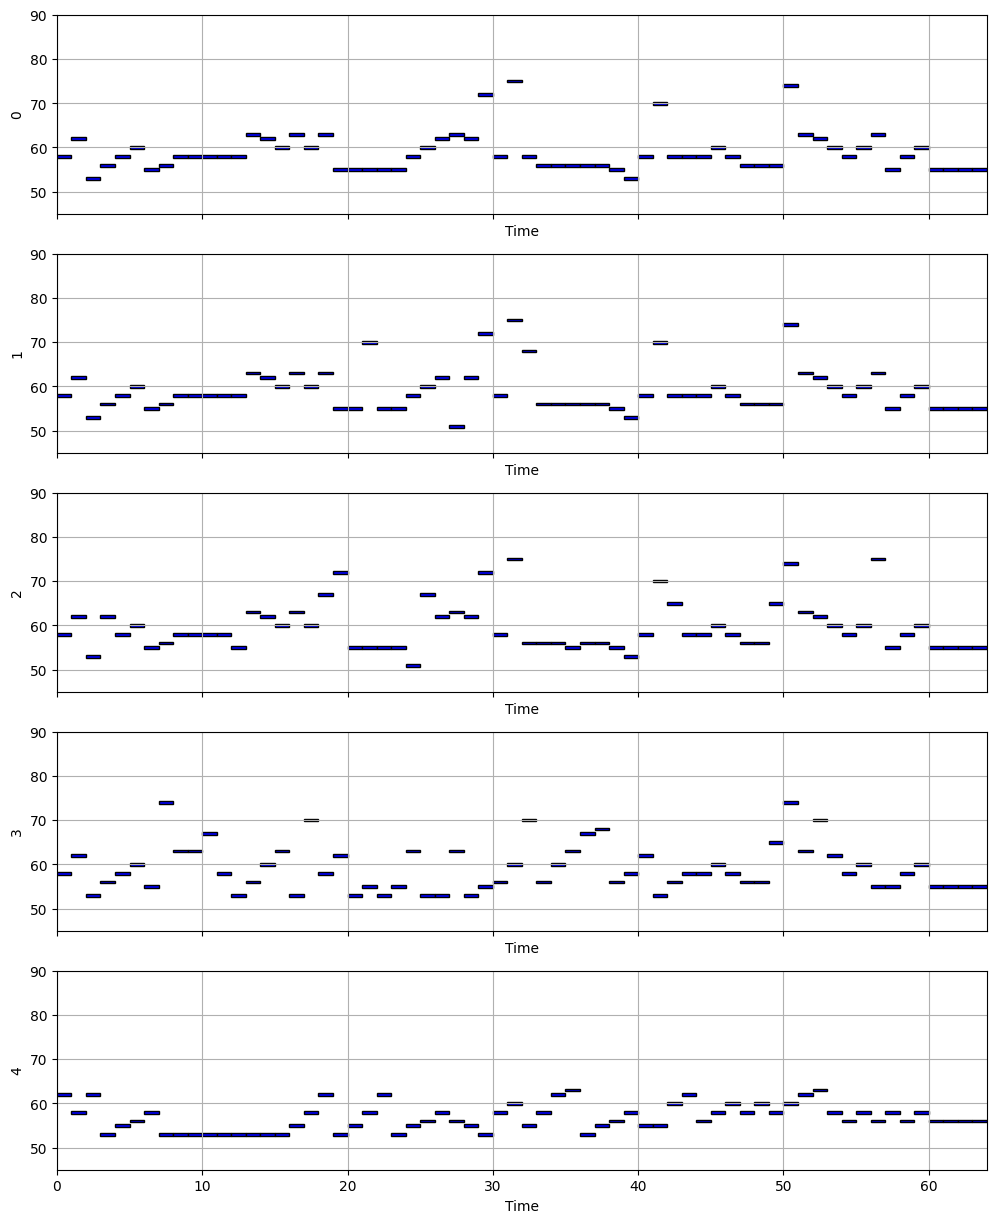

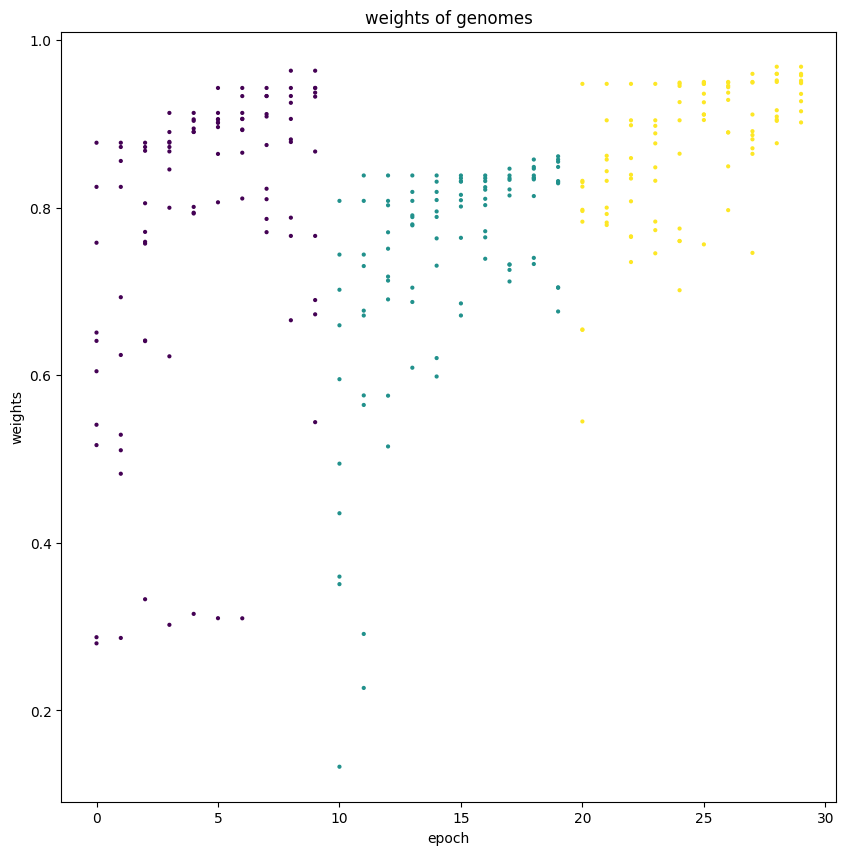

In [34]:
app = tk.Tk()
app.title("Music Generator")

ttk.Label(app, text="Key:").grid(column=0, row=0)
key_var = tk.StringVar(value="major")
ttk.Combobox(app, textvariable=key_var, values=["major", "minor"]).grid(column=1, row=0)

ttk.Label(app, text="Root Note:").grid(column=0, row=1)
root_var = tk.StringVar(value="C")
ttk.Combobox(app, textvariable=root_var, values=["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]).grid(column=1, row=1)

ttk.Label(app, text="Tempo:").grid(column=0, row=2)
tempo_var = tk.IntVar(value=120)
ttk.Entry(app, textvariable=tempo_var).grid(column=1, row=2)

ttk.Button(app, text="Generate", command=generate_music).grid(column=0, row=4, columnspan=2)

# Status label to display completion message
status_var = tk.StringVar(value="")
ttk.Label(app, textvariable=status_var).grid(column=0, row=5, columnspan=2)

app.mainloop()